# LDAS Cloud Use Case

## Demonstrate differences in soil moisture between LDAS model output and CYGNSS satellite retrievals in the Earthdata Cloud

### Audience
Soil moisture researchers who want to see differences between model- and satellite-based products

### Goal
Compare soil moisture from LDAS (NLDAS, GLDAS models) and CYGNSS (satellite retrieval) in different regions of the world (Southern Great Plains, East Africa) using in-region Earthdata Cloud access.

### Assumptions
- A variable of interest is identified
- Data collections of interest are identified
- User has procured access to computing resources in the AWS us-west-2 region

### Preconditions
- User has access to computing resources in the AWS us-west-2 region
- LDAS and CYGNSS data collections are available in the Earthdata Cloud
- Identify area(s) of interest for area-averaging
    - Southern Great Plains: 100-95 W and 32-37 N

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

## Prerequisites

This notebook was written using Python 3.8, and requires these libraries and files:
- xarray
- cartopy
- matplotlib
- S3FS
  - S3FS documentation: (https://s3fs.readthedocs.io/en/latest/install.html)
- netrc file with valid Earthdata Login credentials
- Approval to access the GES DISC archives with your Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login)

## Customize your desired dates range, location, and variables

Specify the following pieces of information upfront, then press play to run code!

- variables
- bounding box
- date range

## Import Libraries

In [1]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os
import requests
import xarray as xr
import s3fs
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Specify variable names for each dataset
nldas_var = "SoilM_0_10cm"
gldas_var = "SoilMoi0_10cm_inst"
cygnss_var = "SM_daily"

# Specify your region of interest bounding box
min_lon = -100
min_lat = 32
max_lon = -95
max_lat = 37

# Specify start and end time and calculate number of days 
start_time = '2018-06-01T00:00:00Z'
end_time = '2018-07-01T00:00:00Z'

from datetime import datetime
start_dt = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%SZ")
end_dt = datetime.strptime(end_time, "%Y-%m-%dT%H:%M:%SZ")
num_days = (end_dt - start_dt).days

num_days

30

## Credentials

Two credentials are required for in-cloud direct S3 access of Earthdata:
 - Earthdata Login username and password
 - Temporary S3 access credential for NASA DAAC archives

The S3 credential is generated by a lambda function that uses the Earthdata Login credentials provided in your <code>.netrc</code> file to create an access key ID, secret access key, and session token for accessing GES DISC S3 buckets. **This token will only last for one hour**, and if time expires, the kernel will need to be reset and the following cell run again. This notebook also accesses data archived by PO.DAAC. You will also need to generate S3 credentials for PO.DAAC.

### STOP: Do you have your Earthdata Login credentials stored in the root directory of this compute system?

If no, run the below cell to store your Earthdata username and password in a <code>.netrc</code> file.
    
If yes, proceed to the next cell.
    


In [3]:
## You may skip this cell if you have already stored your Earthdata Login credentials

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

In [4]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
podaac_s3 = "https://archive.podaac.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials
def begin_s3_direct_access(url: str=gesdisc_s3):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

## Find Data

Use the CMR API to search for the data collections of interest in the desired time range and create a list of S3 URLs that will be accessed. 

### Date Range

- 01 June 2018 - 10 October 2018

### Region

- Southern Great Plains (100-95 W and 32-37 N)

### Data Collections and Variables
| Longname    | Shortname | Variable | CMR Concept ID | Time Resolution | Spatial Resolution |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| [NLDAS Noah Land Surface Model L4 Hourly 0.125 x 0.125 degree V2.0](https://disc.gsfc.nasa.gov/datasets/NLDAS_NOAH0125_H_2.0/summary?keywords=NLDAS_NOAH0125_H) | NLDAS_NOAH0125_H | SoilM_0_10cm | C2069246977-GES_DISC | Hourly | 0.125 deg |
| [GLDAS Noah Land Surface Model L4 3 hourly 0.25 x 0.25 degree V2.1](https://disc.gsfc.nasa.gov/datasets/GLDAS_NOAH025_3H_2.1/summary?keywords=GLDAS_NOAH025_3H_2.1) | GLDAS_NOAH025_3H | SoilMoi0_10cm_inst | C1342986035-GES_DISC | 3-Hourly | 0.25 deg | 
| [UCAR-CU CYGNSS Level 3 Soil Moisture Version 1.0](https://podaac.jpl.nasa.gov/dataset/CYGNSS_L3_SOIL_MOISTURE_V1.0) | CYGNSS_L3_SOIL_MOISTURE_V1.0 | SM_daily | C2205122332-POCLOUD | Daily | ~0.37 deg lon. by ~0.30 deg lat. |



In [5]:
# Create a function for CMR catalog requests
def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

In [6]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

### NLDAS hourly granules 

Use the table above to fill in the concept ID for the NLDAS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [7]:
nldas_concept_id = 'C2069246977-GES_DISC'
page_size = 24*num_days+1
response = cmr_request({
                        'concept_id': nldas_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
nldas_granules = response.json()['feed']['entry']

nldas_s3_urls = []
for granule in nldas_granules:
    nldas_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://")), None))

### GLDAS 3-hourly granules 

Use the table above to fill in the concept ID for the GLDAS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [8]:
gldas_concept_id = 'C1342986035-GES_DISC'
page_size = 8*num_days+1
response = cmr_request({
                        'concept_id': gldas_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
gldas_granules = response.json()['feed']['entry']

gldas_s3_urls = []
for granule in gldas_granules:
    gldas_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://")), None))

### CYGNSS daily granules 

Use the table above to fill in the concept ID for the CYGNSS data collection in the CMR API call. Create a list of S3 URLs based on the CMR response for your search. 

Estimate the number of granules you expect to find based on the time resolution and time range and adjust the page size accordingly.

In [9]:
cygnss_concept_id = 'C2205122332-POCLOUD'
page_size = num_days + 1
response = cmr_request({
                        'concept_id': cygnss_concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': page_size
                        })
cygnss_granules = response.json()['feed']['entry']

cygnss_s3_urls = []
for granule in cygnss_granules:
    cygnss_s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://") and item["href"].endswith(".nc")), None)) 

## Access Data

### Begin S3FS sessions

Begin your S3FS session that you set up earlier in the "Credentials" section.

Remember, these S3FS sessions are specific to the DAAC-owned S3 buckets, so we will create a session for each DAAC we are accessing data from.

In [10]:
fs_gesdisc = begin_s3_direct_access(gesdisc_s3)
fs_podaac = begin_s3_direct_access(podaac_s3)

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(fs_gesdisc), type(fs_podaac)

(s3fs.core.S3FileSystem, s3fs.core.S3FileSystem)

### Open granules using xarray

We will use the xarray Python library to read and open the files we found using the CMR API and put into lists. 

In [11]:
%%time
nldas_ds = xr.open_mfdataset(
    paths=[fs_gesdisc.open(f) for f in nldas_s3_urls[0:num_days*24]],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
)

CPU times: user 8min 14s, sys: 56.7 s, total: 9min 10s
Wall time: 19min 44s


In [12]:
%%time
gldas_ds = xr.open_mfdataset(
    paths=[fs_gesdisc.open(f) for f in gldas_s3_urls[0:num_days*8]],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    parallel=False,
)

CPU times: user 3min 26s, sys: 1.45 s, total: 3min 28s
Wall time: 4min 4s


In [13]:
%%time
cygnss_ds = xr.open_mfdataset(
    paths=[fs_podaac.open(f) for f in cygnss_s3_urls[0:num_days]],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    parallel=False,
)

CPU times: user 11.7 s, sys: 2.64 s, total: 14.3 s
Wall time: 42.4 s


## Process Data

- Match temporal resolution
- Re-grid/interpolate to same spatial resolution
- Create new dataset with interpolated variables
    - Ensure same units
- Subset with the bounding box for desired region
- Remove the data gaps using a mask for CYGNSS

### Match temporal resolution
Resample NLDAS and GLDAS to daily time resolution to match CYGNSS

In [14]:
nldas_ds_daily = nldas_ds.resample(time="1D").mean()
gldas_ds_daily = gldas_ds.resample(time="1D").mean()


### Subset with the bounding box for desired region

- Southern Great Plains: 100-95 W and 32-37 N


- Set coordinates to "latitude" and "longitude" (they're listed as 2D variables in the file)
- Clip to bounding box
- Result maintains original data array dims, but nans fill the non-desired area


In [15]:
# Reassign coordinates using the latitude and longitude variables
cygnss_ds = cygnss_ds.set_coords(("latitude", "longitude"))

# Clip the dataset to the specified bounding box for region of interest
cygnss_ds_region = cygnss_ds.where((cygnss_ds.latitude > min_lat) & (cygnss_ds.latitude < max_lat) & (cygnss_ds.longitude > min_lon) & (cygnss_ds.longitude < max_lon))

#cygnss_ds_region.SM_daily.values.shape
cygnss_ds_region[cygnss_var].values.shape

(30, 252, 802)

Variable names
- NLDAS: NLDAS_SoilM_0_10cm
- GLDAS: GLDAS_SoilMoi0_10cm_inst
- CYGNSS: SM_daily

### Re-grid to same spatial resolution

Interpolate NLDAS/GLDAS to the CYGNSS grid### Test interpolation function

In [16]:
"""
    Name: interpolate_to_cygnss
    
    Interpolates a set of points (NLDAS/GLDAS), to another set of points (CYGNSS)

    Parameters
    ----------
    a_pts: np.meshgrid
        Meshgrid containing the initial set of lat/lon points
        
    values: (X, Y) np.ndarray
        Array of values to be interpolated 
       
    b_pts: np.meshgrid
        Meshgrid containing the final set of lat/lon points that values will be interpolated to
        
    shape: Tuple
        2-D tuple containing the shape of the final interpolated array
        
    Returns
    ----------
    interp: (X, Y) np.ndarray
        Array of final interpolated values

"""

def interpolate_to_cygnss(a_pts, values, b_pts, shape):
    interp = griddata(a_pts, values.values.flatten(), b_pts, method='linear')
    interp = interp.reshape(shape)
    
    return interp

In [17]:
%%time

import concurrent.futures

nx, ny = np.meshgrid(gldas_ds_daily.lon.values, gldas_ds_daily.lat.values)
gldas_pts = np.stack([nx.ravel(), ny.ravel()], axis=1)

nx, ny = np.meshgrid(nldas_ds_daily.lon.values, nldas_ds_daily.lat.values)
nldas_pts = np.stack([nx.ravel(), ny.ravel()], axis=1)

cx, cy = cygnss_ds.longitude[0,:,:].values, cygnss_ds.latitude[0,:,:].values
cygnss_pts = np.stack([cx.ravel(), cy.ravel()], axis=1)

gldas_interp, nldas_interp = [], []


# Create ThreadPoolExecutor for calling the interpolation function                                                

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    gldas_interp_results = [executor.submit(interpolate_to_cygnss, gldas_pts, gldas_ds_daily.SoilMoi0_10cm_inst[i,:,:],
                                            cygnss_pts, cygnss_ds.SM_daily[0,:,:].shape) for i in range(num_days)]
    
    nldas_interp_results = [executor.submit(interpolate_to_cygnss, nldas_pts, nldas_ds_daily.SoilM_0_10cm[i,:,:],
                                            cygnss_pts, cygnss_ds.SM_daily[0,:,:].shape) for i in range(num_days)]

# Put results into lists for concatenation

for gldas_result in concurrent.futures.as_completed(gldas_interp_results):
    gldas_interp.append(gldas_result.result())
    
for nldas_result in concurrent.futures.as_completed(nldas_interp_results):
    nldas_interp.append(gldas_result.result())       

CPU times: user 43min 36s, sys: 35min 47s, total: 1h 19min 24s
Wall time: 20min 32s


## Apply CYGNSS masking to interpolated NLDAS/GLDAS

Create a mask of data gaps (where CYGNSS has nans)

In [19]:
# Create a mask of data gaps (where CYGNSS has nans)
cygnss_mask = np.isnan(cygnss_ds_region.SM_daily)

nldas_masked_da, gldas_masked_da = [], []

# Loop through the length of the lists
for i in range(num_days):
    # Apply the mask to NLDAS
    nldas_masked_values = xr.where(cygnss_mask[i,:,:], np.nan, nldas_interp[i])
    #nldas_masked_values = nldas_masked_values.rename('NLDAS_SoilM_0_10cm')
    nldas_masked_values = nldas_masked_values.rename('NLDAS_'+nldas_var)
    nldas_masked_da.append(nldas_masked_values)

    # Apply the mask to GLDAS
    gldas_masked_values= xr.where(cygnss_mask[i,:,:], np.nan, gldas_interp[i])
    gldas_masked_values = gldas_masked_values.rename('GLDAS_'+gldas_var) 
    gldas_masked_da.append(gldas_masked_values)
    
# Concatenate lists of data arrays into a single Xarray dataset
nldas_masked_ds = xr.concat(nldas_masked_da, dim="time")
gldas_masked_ds = xr.concat(gldas_masked_da, dim="time")

## Derive area-averages

In [20]:
cygnss_aavgs = []
nldas_aavgs = []
gldas_aavgs = []

for i in range(0, num_days):
    cygnss_aavgs.append(np.nanmean(cygnss_ds_region[cygnss_var][i,:,:]))
    nldas_aavgs.append(np.nanmean(nldas_masked_ds[i,:,:].values) / 100)
    gldas_aavgs.append(np.nanmean(gldas_masked_ds[i,:,:].values) / 100)


## Plot time series

(0.1, 0.3)

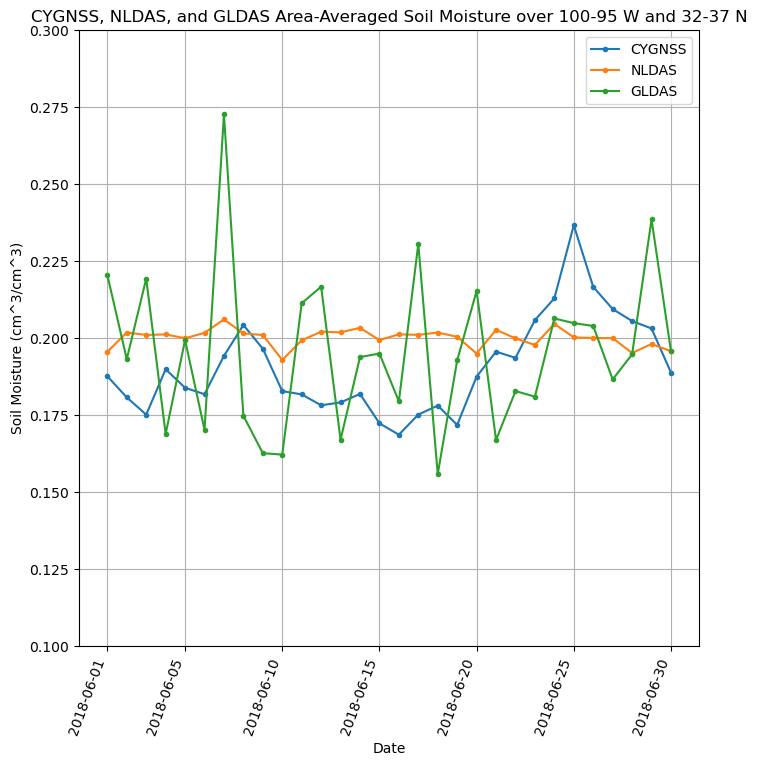

In [25]:
# Figure size
plt.rcParams['figure.figsize'] = 8,8

time_labels = ["2018-06-01", "2018-06-05", "2018-06-10", 
               "2018-06-15", "2018-06-20", "2018-06-25", 
               "2018-06-30"]


# Figure setup
fig, ax = plt.subplots()
ax.plot(cygnss_aavgs, label='CYGNSS', marker=".")
ax.plot(nldas_aavgs, label='NLDAS', marker=".")
ax.plot(gldas_aavgs, label='GLDAS', marker=".")

plt.xlabel("Date")
plt.ylabel("Soil Moisture (cm^3/cm^3)")

ax.set_xticks([0, 4, 9, 14, 19, 24, 29])
ax.set_xticklabels(time_labels, rotation=70, ha='right')

plt.grid()

ax.set_title("CYGNSS, NLDAS, and GLDAS Area-Averaged Soil Moisture over 100-95 W and 32-37 N")

ax.legend()
ax.set_ylim(0.1,0.3)